# Introduction

Control input to the plant is the solution to an optimisation problem, computed at each discrete time step.

This allows us to include constraints, acheive set points closer to optimal while sacrificing robustness and now requirig full state f/b as opposed to traditional methods using output feedback.

- No need for closed-form solution
- Flexible choice of cost function
- Constrained ooptimisation as opposed to including it within the cost function
- Non-linear prediction models are possible

# Unconstrained Predictive Control

Given an initial state $x = x(k)$, compute a finite horizon input sequence

$$\mathbf{u} = \{u_0, u_1, ..., u_{N-1} \}$$

that minimises

$$ V(x, \mathbf{u}) = x_N^T P x_N + \sum^{N-1}_{i=0} (x_i^T Q x_i + u_i^T R u_i) $$

where $x_i$ is the prediction of $x_{k + i}$ with $x_0 = x(k)$

$$V^*(x) \triangleq \min_u V(x,u)$$

The optimal input sequence is defined as:

$$ \begin{align*}
u^*(x) &\triangleq \arg\min V(x,u) \\
 &= \{u_0^*, u_1^*, ..., u_{N-1}^*\}
 \end{align*}$$

The optimal solution is hence given by 


$$ \begin{align*}
 u(k) &= u^*_0(x(k)) \\
 &= -(R + B^T X_1 B)^{-1} B^T x_{k+1} A x(k)  \\
      & = K_{RHC} x(k) 
\end{align*}$$

The parameters are Q, R, P and N. Refer to [`1_optimal_control.ipynb`](1_optimal_control.ipynb) for more details on Discrete-time Finite Horizon LQR that this is based on.

We can now explore stability characteristics by:

1. Fix $Q = P = I$
2. Compute $\rho(A + BK_{RHC})$ over a grid of R and N. 
3. Indicate unstable areas (Eignevalues present outside the unit circle)

## Stability Theorem

The findings of the above section drive us to formulate a method to ensure stability of the control.

1. Q and R are positive definite
2. $(A + BK)^T P(A + BK) - P \leq -Q - K^TRK$

### Proof

Consider the optimal input

$$\mathbf{u}^* = \{u_0^*, u_1^*, ..., u_{N-1}^* \}$$

apply $u_0^*$ and add $Kx^*_N$ to the tail, where $\rho(A + BK) < 1$

$$\mathbf{\tilde{u}} = \{u_1^*, ..., u_{N-1}^*, Kx^*_N \}$$

$$\begin{align*}
V^*(x(k+1)) - V^*(x(k)) &\leq V(x(k+1), \tilde{u}(x)) - V^*(x(k)) \\
&= x_{N+1}^T Px_{N+1} + \sum_{i=1}^N \left(x_i^T Qx_i + u_i^T Ru_i\right) - x_0^T Px_N - \sum_{i=0}^{N-1} \left(x_i^T Qx_i + u_i^T Ru_i\right) \\
&= x_N^T(A + BK)^T P(A + BK)x_N + \left(x_N^T Qx_N + x_N^T K^T RKx_N\right) \\
&\quad - x_N^T Px_N - \left(x_0^T Qx_0 + u_0^T Ru_0\right) \\
&\leq x_N^T((A + BK)^T P(A + BK) - P + Q + K^T RK)x_N - x_0^T Qx_0 \leq -x_0^T Qx_0
\end{align*}$$

so 

$$ V^*(x(k+1)) \leq V^*(x(k)) - x(k)^T Q x(k) $$

This clearly shows that 

$$\lim_{k \to \infty} V^*(x(k)) = 0 \text{ and so } \lim_{k \to \infty} x(k) = 0$$

# Value Function as Terminal Cost

It can be simply shown that setting the terminal cost P to equal the solution of the **DARE**, sets $X_0 = X_1 = ... = X_N = X = P$, with optimal cost $V^*(x) = x^T X_0 x $.

The solution is hence independent of N

$$ V^*(x) = \min_u \left(  x_N^TXx_N + \sum^{N-1}_{i=0} x_i^T Q x_i u_i^T R u_i \right) = x^T X x   $$

for any N from 0 to $ \infty $.

# Constrained Predictive Optimisation

The setup replicates that of the unconstrained version, but now with the addition of linear constraints

$$\begin{align*}
M_i x_i + E_i u_i &\leq b_i \quad \text{for all } i = 0, 1, ..., N-1 \\
M_N x_N &\leq b_N
\end{align*}$$

suppose we have the following constraints

$$\begin{align*}
u_{low} \leq u_i \leq u_{high}, \quad &i = 0, 1, ..., N-1 \\
y_{low} \leq y_i \leq y_{high}, \quad &i = 0, 1, ..., N
\end{align*}$$

where y_i is the observed variable given by $y_i = Cx_i$

defining

$$M_i \triangleq \begin{bmatrix} 0 \\ 0 \\ -C \\ C \end{bmatrix}, \quad E_i \triangleq \begin{bmatrix} -I \\ +I \\ 0 \\ 0 \end{bmatrix}, \quad b_i \triangleq \begin{bmatrix} -u_{low} \\ +u_{high} \\ -y_{low} \\ +y_{high} \end{bmatrix} \quad \text{for } i = 0, 1, ..., N-1$$

and

$$M_N \triangleq \begin{bmatrix} -C \\ +C \end{bmatrix}, \quad b_N \triangleq \begin{bmatrix} -y_{low} \\ +y_{high} \end{bmatrix}.$$

altogether this gives

$$\begin{bmatrix} 
E_0 & 0 & 0 & 0 & \cdots & 0 & 0 \\
0 & M_1 & E_1 & 0 & \cdots & 0 & 0 \\
0 & 0 & 0 & M_2 & \cdots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \cdots & E_{N-1} & 0 \\
0 & 0 & 0 & 0 & \cdots & 0 & M_N
\end{bmatrix}
\begin{bmatrix}
u_0 \\
x_1 \\
u_1 \\
x_2 \\
\vdots \\
u_{N-1} \\
x_N
\end{bmatrix} \leq 
\begin{bmatrix}
-M_0x(k) + b_0 \\
b_1 \\
b_2 \\
\vdots \\
b_{N-1} \\
b_N
\end{bmatrix}$$

$$ \mathcal{G} \theta \leq h $$

This gives

$$ V(x, \theta) = x^T Q x + \theta ^T \Omega \theta $$

where

$$ \Omega =  \begin{bmatrix}
R & 0 & 0 & 0 & \cdots & 0 & 0 \\
0 & Q & 0 & 0 & \cdots & 0 & 0 \\
0 & 0 & R & 0 & \cdots & 0 & 0 \\
0 & 0 & 0 & Q & \cdots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \cdots & R & 0 \\
0 & 0 & 0 & 0 & \cdots & 0 & P
\end{bmatrix}$$


Finally dynamics are given by 

$$\begin{bmatrix}
B & -I & 0 & 0 & \cdots & 0 & 0 \\
0 & A & B & -I & \cdots & 0 & 0 \\
0 & 0 & 0 & A & \cdots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \cdots & B & -I
\end{bmatrix}
\begin{bmatrix}
u_0 \\
x_1 \\
u_1 \\
x_2 \\
\vdots \\
u_{N-1} \\
x_N
\end{bmatrix} = 
\begin{bmatrix}
-Ax(k) \\
0 \\
0 \\
\vdots \\
0
\end{bmatrix}$$

$$\mathcal{A}\theta = b$$

This can now be posed as a Quadratic Prograp (see [`Practical_Optimisation`](https://github.com/ofs416/Practical_Optimisation)) and simply inputted into a solver.

$$\begin{align*}
\min_\theta \quad & \theta^T \Omega\theta \\
\text{subject to:} \quad & \mathcal{G}\theta \leq h \\
& \mathcal{A}\theta = b
\end{align*}$$

with a unique solution given by $\Omega > 0$.

## Example: Double Integrator

In [677]:
import numpy as np
import qpsolvers
from scipy.linalg import block_diag
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt

$$ A = 
\begin{bmatrix}
1 & 1 \\
0 & 1 
\end{bmatrix}, \quad B = 
\begin{bmatrix}
0.5 \\
1 
\end{bmatrix},
\quad C = \begin{bmatrix} 1 & 0  \end{bmatrix}$$

In [678]:
def dynamics(x0, u0, A, B):
    return A @ x0 + B * u0

In [679]:
A = np.array([[1, 1], [0, 1]])
B = np.array([[0.5], [1]])
C = np.array([[1, 0], [0, 1]])

$$ |u| \leq 1, \quad |x_1| \leq 12, \quad N = 20 $$

In [680]:
u_min = -2
u_max = 2
x1_min = -12
x1_max = 12
x2_min = -np.inf
x2_max = np.inf
N = 20

$$ M =\begin{bmatrix} 0 \\ 0 \\ -C \\ C\end{bmatrix}, \quad E = \begin{bmatrix} -I \\ +I \\ 0 \\ 0 \\ 0 \\ 0\end{bmatrix}, \quad b = \begin{bmatrix} 1 \\ 1 \\ 12\\ 0 \\ 12 \\ 0   \end{bmatrix}$$

and 

$$ M_N = \begin{bmatrix} -C \\ C\end{bmatrix}, \quad b_N = \begin{bmatrix}  12 \\ 12   \end{bmatrix}$$

In [681]:
E = np.block([[-1], [1], [np.zeros((2 * C.shape[0], 1))]])

M = np.block([[np.zeros((2 * B.shape[1], C.shape[1]))], [-C], [C]])
b = np.array([[-1 * u_min], [u_max], [-1 * x1_min], [-1 * x2_min], [x1_max], [x2_max]])

M_N = np.block([[-C], [C]])
b_N = np.array([[-1 * x1_min], [-1 * x2_min], [x1_max], [x2_max]])

$$ Q = 
\begin{bmatrix}
1 & 0 \\
0 & 0 
\end{bmatrix} , \quad P = 
\begin{bmatrix}
2 & 1 \\
1 & 1.5 
\end{bmatrix}, \quad R = 1$$

In [682]:
Q = np.array([[1, 0], [0, 0]])
P = np.array([[2, 1], [1, 1.5]])
R = np.array([[1]])

Now we construct $\Omega$, $\mathcal{A}$, $\mathcal{G}$, $h$ and $c$.

In [683]:
h = np.block([[np.block([[b] for _ in range(N)])], [b_N]])

G = block_diag(E, *([np.block([M, E])] * (N - 1)), M_N)

Omega = block_diag(R, *([block_diag(Q, R)] * (N - 1)), P)

A_cal = block_diag(*([np.block([B, -np.eye(B.shape[0])])] * N)) + block_diag(
    np.zeros_like(B),
    *([np.block([A, np.zeros_like(B)])] * (N - 2)),
    np.block([A, np.zeros_like(B), np.zeros((B.shape[0], B.shape[0]))]),
)

In [684]:
qpsolvers.available_solvers

['clarabel', 'osqp', 'qpalm', 'quadprog', 'scs']

In [685]:
Omega_sparse = csc_matrix(Omega)
G_sparse = csc_matrix(G)
A_cal_sparse = csc_matrix(A_cal)

In [686]:
def mpc_step(x0, A, M, h, b, Omega, G, A_cal, **kwargs):
    b0 = np.block([[-A @ x0], [np.zeros((x0.shape[0] * (N - 1), 1))]])
    h0 = h + np.block([[-M @ x0], [np.zeros((h.shape[0] - b.shape[0], 1))]])

    return qpsolvers.solve_qp(
        Omega, np.zeros(Omega.shape[0]), G, h0, A_cal, b0, **kwargs
    )

In [687]:
def mpc(x0, A, M, h, b, Omega, G, A_cal, steps, **kwargs):
    x = np.zeros((x0.shape[0], steps + 1))
    x[:, 0] = x0.flatten()
    u = np.zeros((B.shape[1], steps))
    for i in range(steps):
        u[:, i] = mpc_step(x[:, i, np.newaxis], A, M, h, b, Omega, G, A_cal, **kwargs)[
            0
        ]
        x[:, i + 1] = dynamics(x[:, i, np.newaxis], u[:, i], A, B).flatten()
    return x, u

In [688]:
x0 = np.array([[7], [3]])

x_hist, u_hist = mpc(
    x0,
    A,
    M,
    h,
    b,
    Omega_sparse,
    G_sparse,
    A_cal_sparse,
    20,
    solver="osqp",
    verbose=False,
)

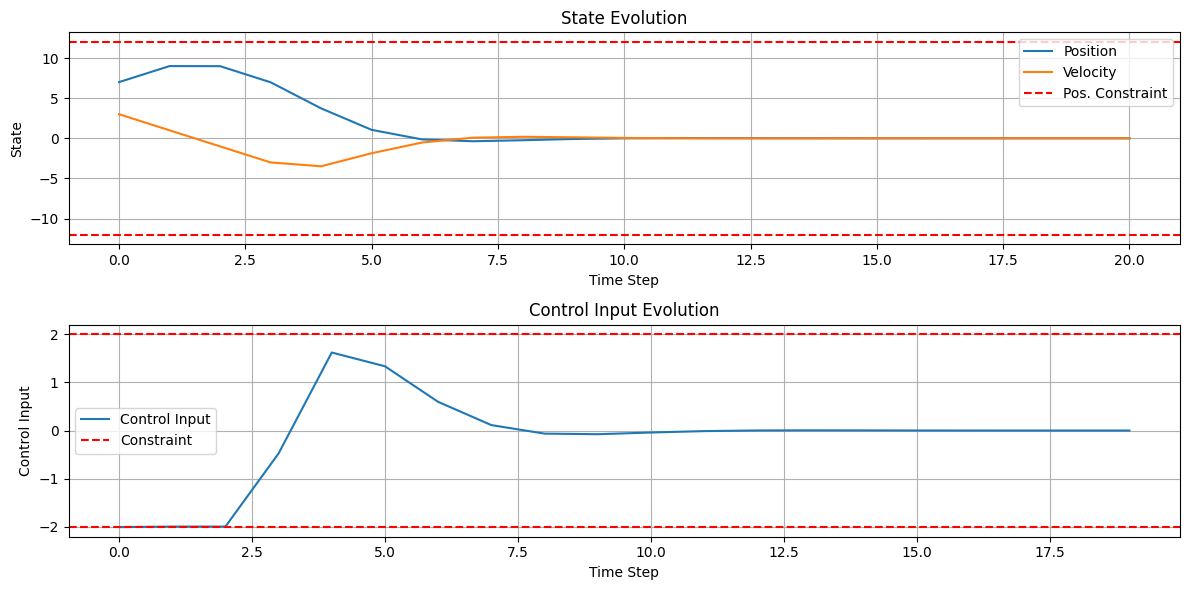

In [689]:
# Plot the state x
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(x_hist[0, :], label="Position")
plt.plot(x_hist[1, :], label="Velocity")
plt.axhline(y=x1_max, color="r", linestyle="--", label="Pos. Constraint")
plt.axhline(y=x1_min, color="r", linestyle="--")
plt.title("State Evolution")
plt.xlabel("Time Step")
plt.ylabel("State")
plt.legend()
plt.grid(True)


# Plot the control input u
plt.subplot(2, 1, 2)
plt.plot(u_hist[0, :], label="Control Input")
plt.title("Control Input Evolution")
plt.axhline(y=u_max, color="r", linestyle="--", label="Constraint")
plt.axhline(y=u_min, color="r", linestyle="--")
plt.xlabel("Time Step")
plt.ylabel("Control Input")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Below we highlight that a single step is identical to the above case as our model perfectly captures the dynamics, therefore below is merely **constrained optimal control**

In [690]:
data = mpc_step(
    x0,
    A,
    M,
    h,
    b,
    Omega_sparse,
    G_sparse,
    A_cal_sparse,
    solver="osqp",
    verbose=False,
)

x_hist = np.array([x for i in range(1, len(data), 3) for x in data[i : i + 2]]).reshape(
    -1, 2
)
u_hist = np.array(data[0::3])

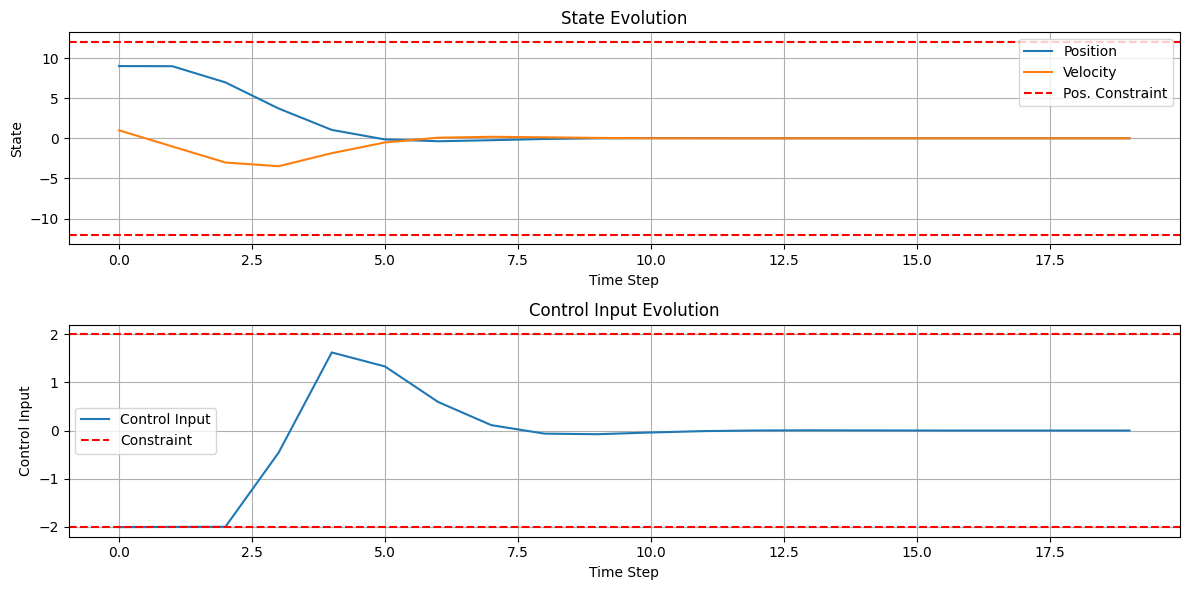

In [691]:
# Plot the state x
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(x_hist[:, 0], label="Position")
plt.plot(x_hist[:, 1], label="Velocity")
plt.axhline(y=x1_max, color="r", linestyle="--", label="Pos. Constraint")
plt.axhline(y=x1_min, color="r", linestyle="--")
plt.title("State Evolution")
plt.xlabel("Time Step")
plt.ylabel("State")
plt.legend()
plt.grid(True)

# Plot the control input u
plt.subplot(2, 1, 2)
plt.plot(u_hist, label="Control Input")
plt.title("Control Input Evolution")
plt.axhline(y=u_max, color="r", linestyle="--", label="Constraint")
plt.axhline(y=u_min, color="r", linestyle="--")
plt.xlabel("Time Step")
plt.ylabel("Control Input")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Example: Single Pendulum

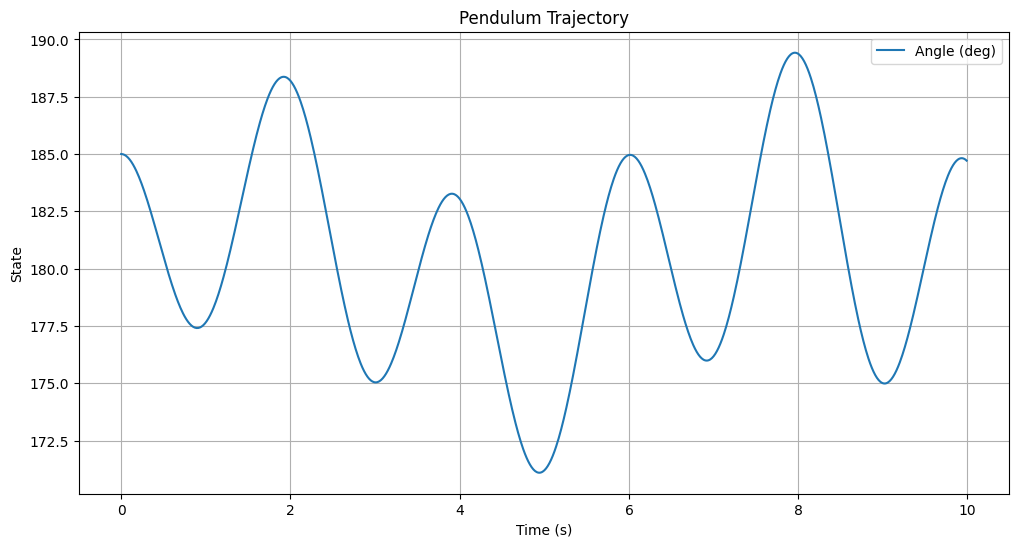

In [692]:
def pendulum_dynamics(x, u, length=1.0, g=9.81, dt=0.01):
    theta, theta_dot = x
    theta_ddot = (g / length) * np.sin(theta) + u / (length**2)
    theta_dot_new = theta_dot + theta_ddot * dt
    theta_new = theta + theta_dot * dt + 0.5 * theta_ddot * dt**2
    return np.array([theta_new, theta_dot_new])

def linearize_pendulum_dynamics(length=1.0, g=9.81, dt=0.01):
    A_cont = np.array([[0, 1], 
                      [-g / length, 0]])
    B_cont = np.array([[0], 
                       [1 / (length**2)]])

    # Discretize using Euler method
    A_disc = np.eye(2) + A_cont * dt
    B_disc = B_cont * dt
    return A_disc, B_disc

# Simulate pendulum trajectory
theta_start = np.deg2rad(185)  # Convert 5 degrees to radians
x_start = np.array([theta_start, 0])  # Initial state: [theta, theta_dot]
time = 10 # Number of simulation steps
dt = 0.01  # Time step
steps = int(time / dt)
trajectory = np.zeros((steps, 2))
trajectory[0] = x_start

for i in range(1, steps):
    u = 0.5 * np.sin(i * dt) 
    trajectory[i] = pendulum_dynamics(trajectory[i-1], u, dt=dt)  # No control input (u=0)

# Plot the pendulum trajectory
time = np.arange(steps) * dt  # Time array in seconds
plt.figure(figsize=(12, 6))
plt.plot(time, np.rad2deg(trajectory[:, 0]), label="Angle (deg)")
plt.title("Pendulum Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("State")
plt.legend()
plt.grid(True)
plt.show()

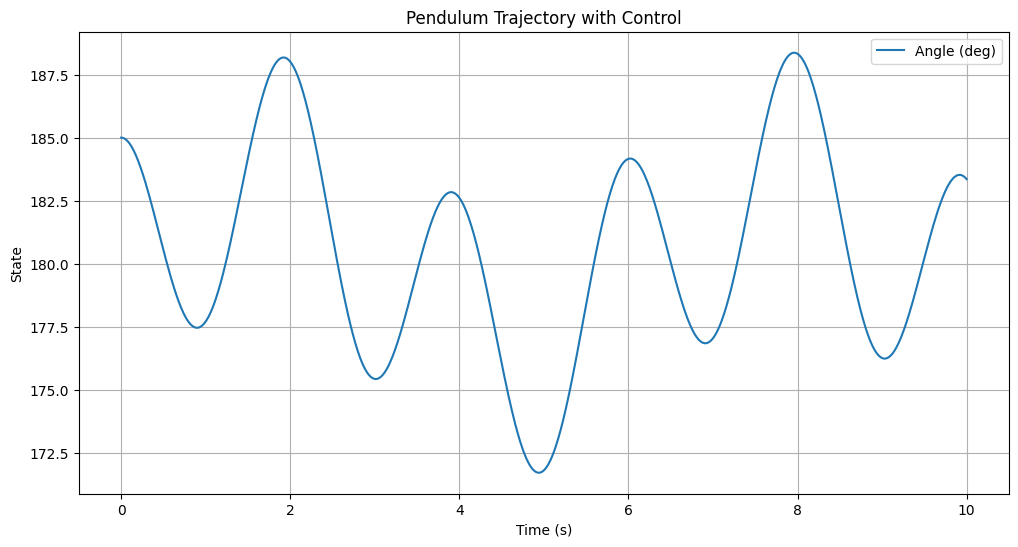

In [693]:
from scipy.integrate import solve_ivp

# Define the pendulum dynamics as an ODE with control input
def pendulum_ode(t, y, u, length=1.0, g=9.81):
    theta, theta_dot = y
    theta_ddot = (g / length) * np.sin(theta) + u / (length**2)
    return [theta_dot, theta_ddot]

# Initial conditions
theta_start = np.deg2rad(185)  # Convert 185 degrees to radians
x_start = [theta_start, 0]  # Initial state: [theta, theta_dot]

# Time span for the simulation
t_span = (0, 10)  # 10 seconds
dt = 0.01
t_eval = np.arange(t_span[0], t_span[1] + dt, dt)  # Time points where solution is computed

# Define the control input as an array matching the time/dt
control_input = 0.5 * np.sin(t_eval)  # Example control input, can be replaced with actual control input

# Solve the ODE with control input step by step
def solve_pendulum_with_control_step_by_step(t_span, x_start, t_eval, control_input):
    y = np.zeros((len(t_eval), len(x_start)))
    y[0] = x_start
    for i in range(1, len(t_eval)):
        t = t_eval[i-1:i+1]
        u = control_input[i-1]
        sol = solve_ivp(pendulum_ode, (t[0], t[1]), y[i-1], args=(u,), t_eval=t)
        y[i] = sol.y[:, -1]
    return t_eval, y

t_eval, solution = solve_pendulum_with_control_step_by_step(t_span, x_start, t_eval, control_input)

# Extract the solution
theta = solution[:, 0]
theta_dot = solution[:, 1]

# Plot the pendulum trajectory
plt.figure(figsize=(12, 6))
plt.plot(t_eval, np.rad2deg(theta), label="Angle (deg)")
plt.title("Pendulum Trajectory with Control")
plt.xlabel("Time (s)")
plt.ylabel("State")
plt.legend()
plt.grid(True)
plt.show()

## Feasibility Theorem

- P, Q and R are positive definite
- $\rho(A + BK_{RHC}) < 1$ 
- $ V(x, \mathbf{u}) = x_N^T P x_N + \sum^{N-1}_{i=0} (x_i^T Q x_i + u_i^T R u_i) $
- $x_0 = x, \quad x_{i+1} = Ax_i + Bu_i$
- $M_i x_i + E_i u_i \leq b_i \quad \text{for all } i = 0, 1, ..., N-1 \quad M_N x_N \leq b_N $

S is an **invariant set** 

$$ S \subset \mathbb{R}^n$$

for a system if

$$x(0) \in S \implies f(x(k)) \in S , \forall k \geq 0$$

S is **constraint admissable** if 

$$(x, \kappa(x)) \in Z \subset \mathbb{R}^n \times \mathbb{R}^m,  \forall x \in S $$

We finally construct 

$$S = \{x \in \mathbb{R}^N : M_Nx \leq b_N, \quad (x, \kappa(x)) \in Z, \quad f(x) \in S \}$$

where

$$ u = \kappa(x) = Kx$$

$$ f(x) = Ax+Bu $$

$$ Z = \{(x, u) : Mx + Eu \leq b\}

Similarly to the unconstrained case we assume $u_N^* = Kx_N^*$ for the end of the horizon onwards.

If $\mathbf{u}^*(x)$ is feasible at time k, then the shifted sequence $\tilde{\mathbf{u}}(x)$ is feasible at time $k+1$ with the implementation of $u(k) = u^*_0(x)$ due to the choice of $M_N$ and $b_N$ as given by above. This acts as an upper-bound on the control problem.

## Stability Theorem

**Stability Definition**:  $\forall \epsilon > 0, \exists \delta > 0 : |x(0)| < \delta \implies |x(k)| < \epsilon, \forall k > 0$

**Asymptotic Stabiility** $\implies \epsilon \rightarrow 0 \text{ as } k \rightarrow \infty$

**Lyapunov Function**: $V:S\rightarrow \mathbb{R} \iff
\begin{cases}
V(0) = 0 \\
V(x) > 0, \forall x \in S, x \neq 0 \\
V(f(x)) - V(x) \leq 0, \forall x \in S
\end{cases}$

We propose there exists a Lyapunov function that exists with the region of attraction S based on the constraints and dynamics. If S is the whole space it is said to be globally asymptotically stable.

It turns out that the proof is identical to the unconstrained case with the solution given by 

- $(A + BK)^T P(A + BK) - P \leq -Q - K^TRK$

# Constrained Infinite Horizon LQR

$$V_\infty^*(x) = \min_u \sum_{i=0}^{\infty} x_i^T Q x_i + u_i^T R u_i$$


$$
\text{subject to }
x_0 = x , \quad
x_{i+1} = Ax_i + Bu_i ,\quad
Mx_i + Eu_i < b , \quad 
 \forall i
$$

$$\leq V^*(x) = \min_u \sum_{i=0}^{\infty} x_i^T Q x_i + u_i^T R u_i = \min_u \sum_{i=0}^{N-1} x_i^T Q x_i + u_i^T R u_i + x_N^T P x_N$$

$$
\text{subject to }
x_0 = x ,\quad
x_{i+1} = Ax_i + Bu_i ,\quad
Mx_i + Eu_i < b \;\; \forall i < N ,\quad
M_N x_N < b_N
$$

Where $P$ is the solution given by the **DARE**.

Therefore we have provided evidence that the terminal constraints allows us to copmute the upper-bound of this infinite problem.


Stability is now proved via

$$V(Ax + Bu_0(x)) = \min_u \sum_{i=1}^{\infty} x_i^T Q x_i + u_i^T R u_i + x_N^T P x_N$$

$$
< V(x) = \min_u \sum_{i=0}^{\infty} x_i^T Q x_i + u_i^T R u_i + x_N^T P x_N
$$

$$
\text{subject to }
x_1 = Ax + Bu_0(x) ,\quad
x_{i+1} = Ax_i + Bu_i ,\quad
Mx_i + Eu_i < b ,\quad
\forall i ,\quad
M_N x_N < b_N \quad
$$